In [30]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import kerastuner as kt
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Concatenate, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing import image as keras_image
from keras.utils import to_categorical

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries



In [2]:
def preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img = keras_image.img_to_array(img)
    img /= 255.0  # Normalize image
    return img

base_path = "/Users/nataliamiela/Documents/master/ML2/project/data/Alzheimers"

# Label folders
labels_folders = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Process and label data
data = []
for label, folder in enumerate(labels_folders):
    folder_path = os.path.join(base_path, folder)
    for image_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        image_path = os.path.join(folder_path, image_name)
        try:
            img = preprocess_image(image_path)
            data.append((img, label))  # Append image and its integer label
        except Exception as e:
            print(f"Error processing file {image_name} in {folder}: {e}")

Processing Very_Mild_Demented: 100%|██████████| 2240/2240 [00:01<00:00, 2004.60it/s]


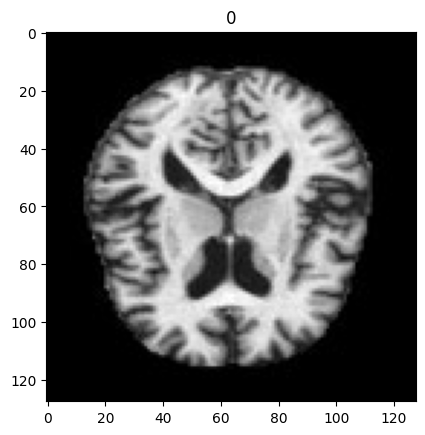

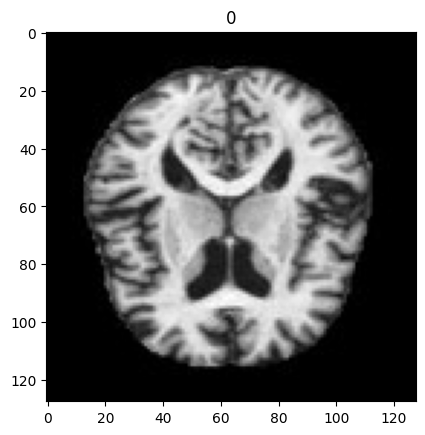

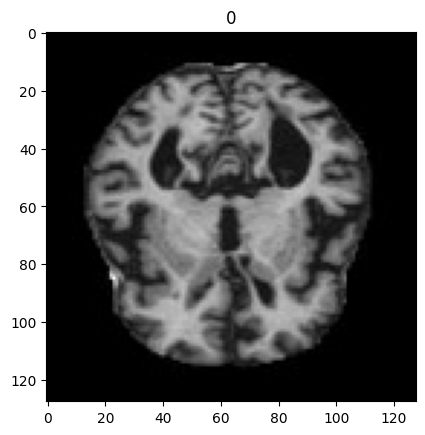

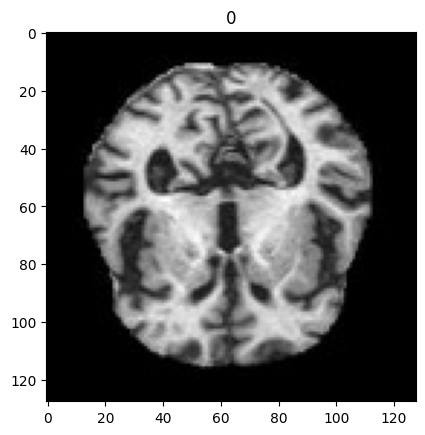

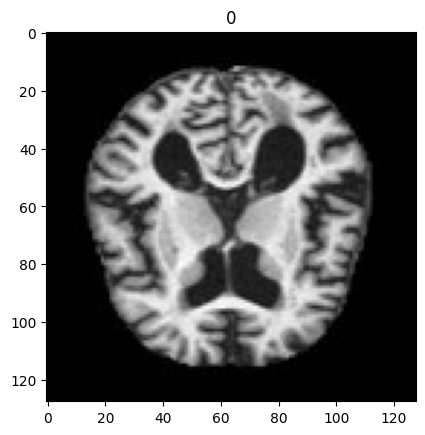

In [3]:
# Check
for i in range(5):
    plt.imshow(data[i][0], cmap = 'gray')
    plt.title(data[i][1])
    plt.show()


In [4]:
# Encoding
def encodingLabels(categories):
  classes_names={}
  for i in range(len(categories)):
    classes_names[i]=categories[i]
  return classes_names

label_names = encodingLabels(labels_folders)
label_names

{0: 'Mild_Demented',
 1: 'Moderate_Demented',
 2: 'Non_Demented',
 3: 'Very_Mild_Demented'}

In [5]:
# Print the shape to confirm
print("Data shape:", data[0][0].shape)

Data shape: (128, 128, 1)


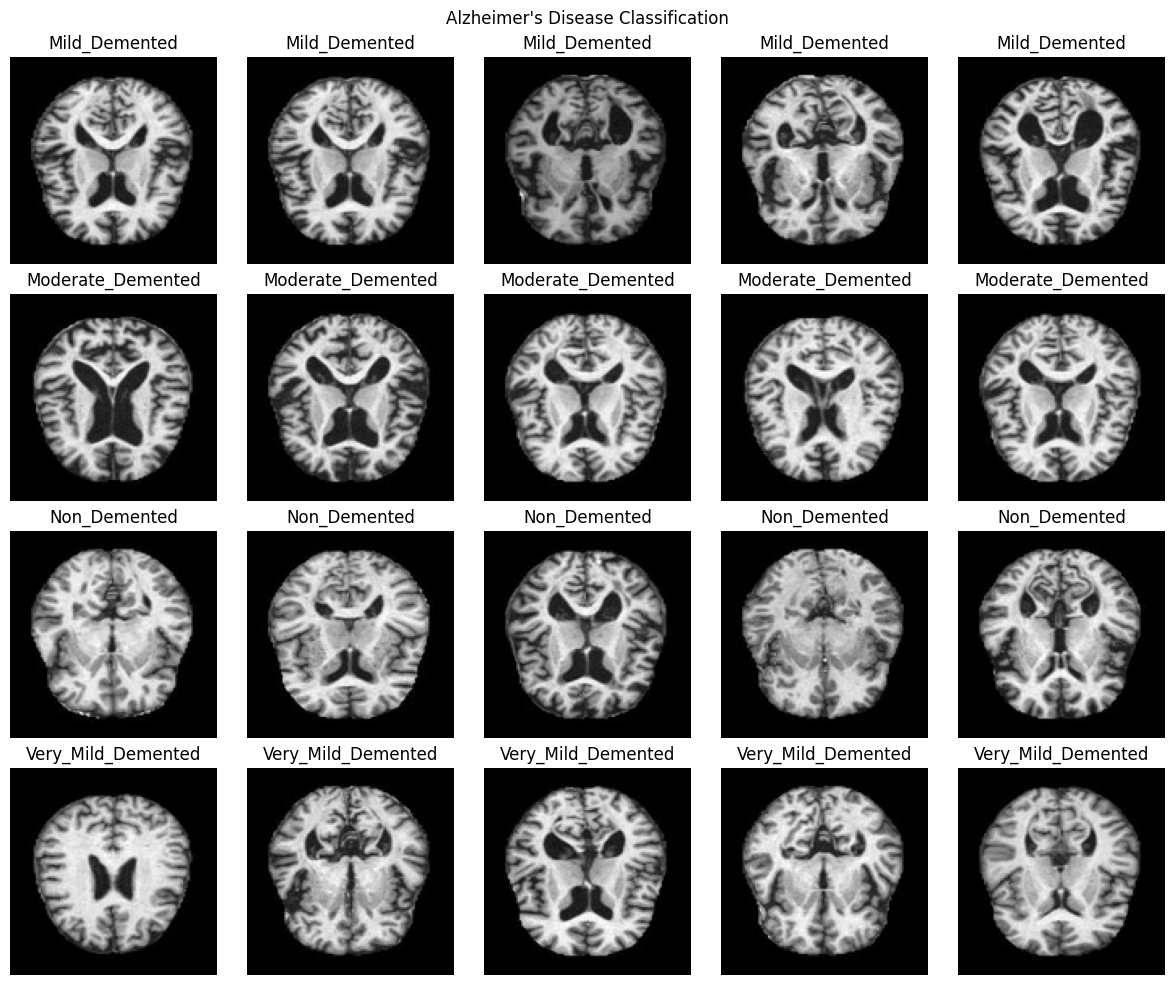

In [6]:
# Function to plot a specified number of images from each category with names
def plot_alzheimers_images_with_names(data_list, title, num_images_per_class=5, cmap='gray'):
    plt.figure(figsize=(12, 10))



    for j, class_name in enumerate(labels_folders):
        # Filter data_list for the current class
        class_data = [item for item in data_list if item[1] == j]
        for i, (img, label) in enumerate(class_data[:num_images_per_class]):
            plt.subplot(len(labels_folders), num_images_per_class, j * num_images_per_class + i + 1)
            plt.imshow(img.reshape(128, 128), cmap=cmap)
            plt.title(class_name)
            plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_alzheimers_images_with_names(data, 'Alzheimer\'s Disease Classification', num_images_per_class=5)


In [7]:
# Shuffle data
np.random.shuffle(data)
shuffled_images, shuffled_labels = zip(*data)
shuffled_images, shuffled_labels = np.array(shuffled_images), np.array(shuffled_labels)

In [8]:
# Train, validation, test split
X_train, X_temp, y_train, y_temp = train_test_split(shuffled_images, shuffled_labels, test_size=0.4, stratify=shuffled_labels, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [9]:
# Class counts y-train
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
class_counts_tr = dict(zip(unique_tr, counts_tr))

print(class_counts_tr)

{0: 538, 1: 38, 2: 1920, 3: 1344}


In [10]:
# Class counts y-valid
unique_val, counts_val = np.unique(y_val, return_counts=True)
class_counts_val = dict(zip(unique_val, counts_val))

print(class_counts_val)

{0: 179, 1: 13, 2: 640, 3: 448}


In [11]:
# Class counts y-test
unique_te, counts_te = np.unique(y_test, return_counts=True)
class_counts_te = dict(zip(unique_te, counts_te))

print(class_counts_te)

{0: 179, 1: 13, 2: 640, 3: 448}


In [12]:
# Total
total_class_counts_tr = sum(class_counts_tr.values())
tr_class_counts = list(class_counts_tr.values())

total_class_counts_tr, tr_class_counts

(3840, [538, 38, 1920, 1344])

In [13]:
# Calculate class weights
class_weights = {}
for i, count in enumerate(tr_class_counts):
    class_weights[i] = total_class_counts_tr / (len(tr_class_counts) * count)

print(class_weights)

{0: 1.7843866171003717, 1: 25.263157894736842, 2: 0.5, 3: 0.7142857142857143}


In [14]:
# Convert labels to one-hot encoding
num_classes = len(labels_folders)
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

### Feedforward NN

In [ ]:
# Define and compile first model draft - feedforward NN
model = Sequential([
    Flatten(input_shape=(128, 128, 1)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


2024-01-21 18:52:27.981638: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-21 18:52:27.981661: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-21 18:52:27.981671: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-21 18:52:27.981709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-21 18:52:27.981725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Train model
base_model = model.fit(
    X_train, y_train_encoded,
    epochs=50,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stopping]
)

Epoch 1/50
  1/120 [..............................] - ETA: 42s - loss: 1.4492 - accuracy: 0.3125

2024-01-21 18:52:28.465198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 3s 18ms/step - loss: 2.6537 - accuracy: 0.4383 - val_loss: 0.9865 - val_accuracy: 0.5234
Epoch 2/50
120/120 [==============================] - 2s 16ms/step - loss: 1.3203 - accuracy: 0.4664 - val_loss: 2.2926 - val_accuracy: 0.4195
Epoch 3/50
120/120 [==============================] - 2s 17ms/step - loss: 1.4293 - accuracy: 0.4781 - val_loss: 1.3480 - val_accuracy: 0.5031
Epoch 4/50
120/120 [==============================] - 2s 20ms/step - loss: 0.9925 - accuracy: 0.5383 - val_loss: 1.3314 - val_accuracy: 0.5070
Epoch 5/50
120/120 [==============================] - 2s 17ms/step - loss: 1.1625 - accuracy: 0.5060 - val_loss: 0.9219 - val_accuracy: 0.5633
Epoch 6/50
120/120 [==============================] - 2s 20ms/step - loss: 1.0744 - accuracy: 0.5365 - val_loss: 0.9121 - val_accuracy: 0.5898
Epoch 7/50
120/120 [==============================] - 2s 19ms/step - loss: 0.9411 - accuracy: 0.5862 - val_loss: 0.8807 - val_accuracy: 0.5852
Epoch 8/50

In [ ]:
# Predict 
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

40/40 [==============================] - 0s 4ms/step


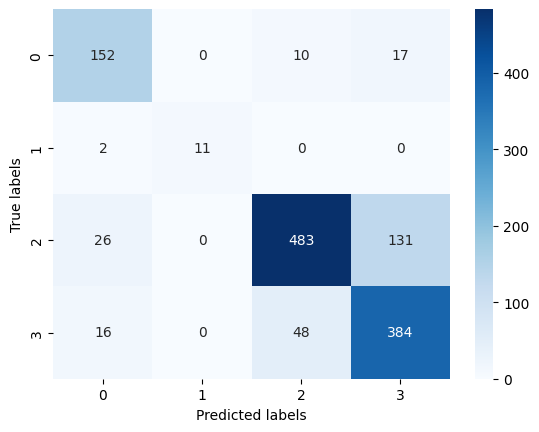

In [ ]:
# Confusion Matrix
confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
# Classification Report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       179
           1       1.00      0.85      0.92        13
           2       0.89      0.75      0.82       640
           3       0.72      0.86      0.78       448

    accuracy                           0.80      1280
   macro avg       0.85      0.83      0.83      1280
weighted avg       0.82      0.80      0.81      1280



### Feedforward NN- hyperparameters tuning

In [21]:
# !pip install keras-tuner

In [38]:
# Define model for FNN with hyperparameters
def build_model(hp):
    model = Sequential([
        Flatten(input_shape=(128, 128, 1)),
        Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu'),
        Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Learning rate
    lr = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001, 0.00001])

    model.compile(optimizer=optimizers.legacy.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='basic_FNN')

# Hyperparameter search
tuner.search(X_train, y_train_encoded, epochs=50, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/basic_FNN/tuner0.json


In [39]:
print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")

Best Hyperparameters:
units1: 160
units2: 256
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021


In [40]:
# Build the model with the best hyperparameters and train it on the data for 50 epochs
model_tuned_basic_fnn = build_model(best_hps)
model_tuned_basic_fnn.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

Epoch 1/50
120/120 [==============================] - 3s 20ms/step - loss: 1.0643 - accuracy: 0.4674 - val_loss: 1.1034 - val_accuracy: 0.5000
Epoch 2/50
120/120 [==============================] - 2s 17ms/step - loss: 0.9697 - accuracy: 0.5109 - val_loss: 0.9800 - val_accuracy: 0.5016
Epoch 3/50
120/120 [==============================] - 2s 17ms/step - loss: 0.9137 - accuracy: 0.5557 - val_loss: 0.9189 - val_accuracy: 0.5492
Epoch 4/50
120/120 [==============================] - 2s 19ms/step - loss: 0.8973 - accuracy: 0.5690 - val_loss: 0.8876 - val_accuracy: 0.5844
Epoch 5/50
120/120 [==============================] - 2s 19ms/step - loss: 0.8661 - accuracy: 0.5956 - val_loss: 0.8776 - val_accuracy: 0.5945
Epoch 6/50
120/120 [==============================] - 2s 17ms/step - loss: 0.8255 - accuracy: 0.6193 - val_loss: 0.8620 - val_accuracy: 0.5906
Epoch 7/50
120/120 [==============================] - 2s 17ms/step - loss: 0.7919 - accuracy: 0.6326 - val_loss: 0.8495 - val_accuracy: 0.5914

In [41]:
# Predict 
y_pred_basic_fnn = model_tuned_basic_fnn.predict(X_test)
y_pred_classes_basic_fnn = np.argmax(y_pred, axis=1)

40/40 [==============================] - 0s 5ms/step


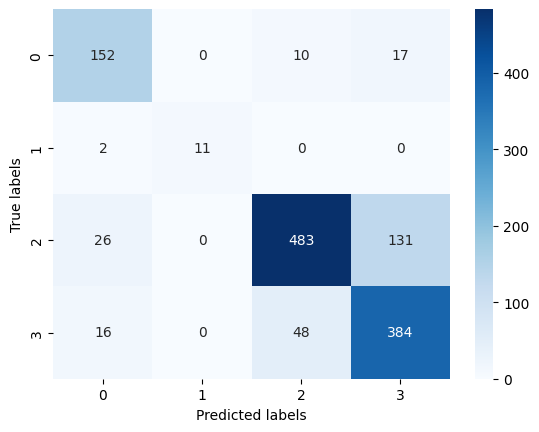

In [42]:
# Confusion Matrix
confusion_Matrix_basic_fnn = confusion_matrix(y_test, y_pred_classes_basic_fnn)
sns.heatmap(confusion_Matrix_basic_fnn, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [43]:
# Classification Report
print(classification_report(y_test, y_pred_classes_basic_fnn))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       179
           1       1.00      0.85      0.92        13
           2       0.89      0.75      0.82       640
           3       0.72      0.86      0.78       448

    accuracy                           0.80      1280
   macro avg       0.85      0.83      0.83      1280
weighted avg       0.82      0.80      0.81      1280



### Enhance FNN model with class weights

In [15]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)


{0: 1.7843866171003717, 1: 25.263157894736842, 2: 0.5, 3: 0.7142857142857143}


In [45]:
# Tuned FNN with class weights
model_tuned_basic_fnn_class_weights = tuner.hypermodel.build(best_hps)

base_fnn_class_weights = model_tuned_basic_fnn_class_weights.fit(
    X_train, y_train_encoded,
    epochs=50,
    validation_data=(X_val, y_val_encoded),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)


Epoch 1/50
120/120 [==============================] - 3s 20ms/step - loss: 1.6426 - accuracy: 0.2971 - val_loss: 1.2162 - val_accuracy: 0.4625
Epoch 2/50
120/120 [==============================] - 2s 16ms/step - loss: 1.4068 - accuracy: 0.3690 - val_loss: 1.5220 - val_accuracy: 0.2898
Epoch 3/50
120/120 [==============================] - 2s 16ms/step - loss: 1.4528 - accuracy: 0.3589 - val_loss: 1.4238 - val_accuracy: 0.2742
Epoch 4/50
120/120 [==============================] - 2s 17ms/step - loss: 1.2519 - accuracy: 0.4326 - val_loss: 1.6081 - val_accuracy: 0.1875
Epoch 5/50
120/120 [==============================] - 3s 22ms/step - loss: 1.1392 - accuracy: 0.4135 - val_loss: 1.2775 - val_accuracy: 0.3664
Epoch 6/50
120/120 [==============================] - 2s 19ms/step - loss: 1.0813 - accuracy: 0.4508 - val_loss: 1.1697 - val_accuracy: 0.4586
Epoch 7/50
120/120 [==============================] - 2s 17ms/step - loss: 0.9276 - accuracy: 0.5242 - val_loss: 1.0807 - val_accuracy: 0.4922

In [47]:
# Predict 
y_pred_fnn_class_weights = model_tuned_basic_fnn_class_weights.predict(X_test)
y_pred_classes_class_weights = np.argmax(y_pred_fnn_class_weights, axis=1)

40/40 [==============================] - 0s 5ms/step


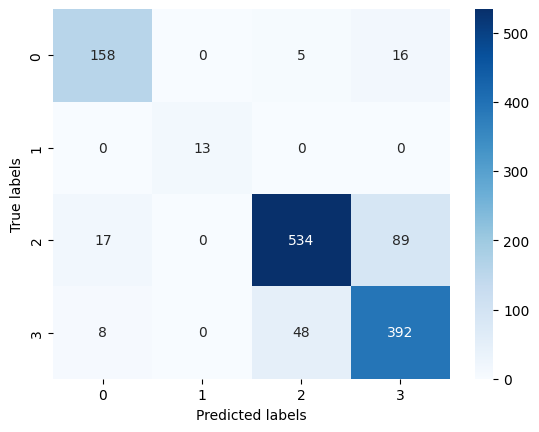

In [48]:
# Confusion Matrix
confusion_Matrix_fnn_class_weights = confusion_matrix(y_test, y_pred_classes_class_weights)
sns.heatmap(confusion_Matrix_fnn_class_weights, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [49]:
# Classification Report
print(classification_report(y_test, y_pred_classes_class_weights))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       179
           1       1.00      1.00      1.00        13
           2       0.91      0.83      0.87       640
           3       0.79      0.88      0.83       448

    accuracy                           0.86      1280
   macro avg       0.89      0.90      0.89      1280
weighted avg       0.86      0.86      0.86      1280



### Convolutional NN-  hyperparameter tuning

In [18]:
def build_hypermodel(hp):
    model = Sequential()

    # First Convolutional Block with tunable number of filters
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=64, max_value=128, step=64),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.3, step=0.1)))

    # Second Convolutional Block
    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=64, max_value=128, step=64),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.3, step=0.1)))

    # Third Convolutional Block
    model.add(Conv2D(filters=hp.Int('conv_3_filters', min_value=64, max_value=128, step=64),
                     kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.3, step=0.1)))

    # Flattening and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=64), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.3, step=0.1)))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer with a neuron for each class

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Set up the tuner
tuner = kt.Hyperband(build_hypermodel,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_cnn',
                     project_name='cnn_tuning_1')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Hyperparameter search
tuner.search(X_train, y_train_encoded,
             epochs=100,
             validation_data=(X_val, y_val_encoded),
             class_weight=class_weights_dict,
             callbacks=[early_stopping])

# Best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from my_dir_cnn/cnn_tuning_1/tuner0.json


In [19]:
print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")

Best Hyperparameters:
conv_1_filters: 128
conv_1_kernel: 3
dropout_1: 0.2
conv_2_filters: 128
conv_2_kernel: 3
dropout_2: 0.2
conv_3_filters: 128
conv_3_kernel: 3
dropout_3: 0.0
dense_units: 64
dropout_4: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018


In [24]:
# Build the model with the best hyperparameters
model_cnn = build_hypermodel(best_hps)

In [43]:
cnn_tuned_model = model_cnn.fit(
    X_train, y_train_encoded,
    epochs=150,  
    validation_data=(X_val, y_val_encoded),
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[early_stopping]
)

Epoch 1/150
120/120 [==============================] - 22s 180ms/step - loss: 0.0528 - accuracy: 0.9776 - val_loss: 0.9845 - val_accuracy: 0.8039
Epoch 2/150
120/120 [==============================] - 21s 172ms/step - loss: 0.0630 - accuracy: 0.9714 - val_loss: 0.1737 - val_accuracy: 0.9414
Epoch 3/150
120/120 [==============================] - 21s 174ms/step - loss: 0.0215 - accuracy: 0.9919 - val_loss: 0.1574 - val_accuracy: 0.9477
Epoch 4/150
120/120 [==============================] - 20s 171ms/step - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.1009 - val_accuracy: 0.9633
Epoch 5/150
120/120 [==============================] - 21s 172ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.1841 - val_accuracy: 0.9375
Epoch 6/150
120/120 [==============================] - 22s 180ms/step - loss: 0.0124 - accuracy: 0.9953 - val_loss: 0.1365 - val_accuracy: 0.9555
Epoch 7/150
120/120 [==============================] - 22s 183ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.1047 -

In [39]:
# Save model
model_cnn.save('cnn_tuned_model.h5')

In [40]:
# Predict 
y_pred_cnn_tuned = model_cnn.predict(X_test)
y_pred_classes_cnn_tuned = np.argmax(y_pred_cnn_tuned, axis=1)

40/40 [==============================] - 3s 70ms/step


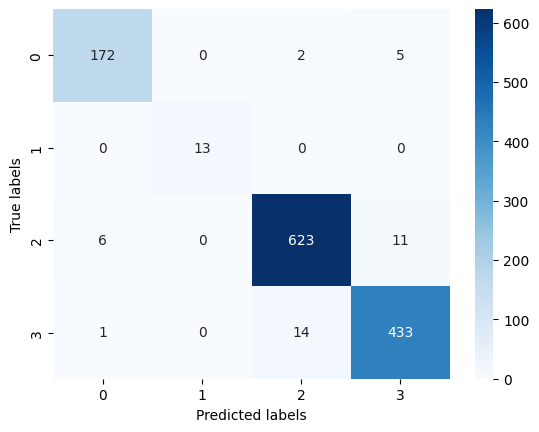

In [41]:
# Confusion Matrix
confusion_Matrix_cnn_tuned = confusion_matrix(y_test, y_pred_classes_cnn_tuned)
sns.heatmap(confusion_Matrix_cnn_tuned, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [42]:
# Classification Report
print(classification_report(y_test, y_pred_classes_cnn_tuned)) 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       179
           1       1.00      1.00      1.00        13
           2       0.97      0.97      0.97       640
           3       0.96      0.97      0.97       448

    accuracy                           0.97      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.97      0.97      0.97      1280



### Hybrid model- Transfer learning ResNet with CNN

In [16]:
# Load the ResNet model without the top layer
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
X_train_resnet = np.repeat(X_train, 3, axis=-1)
X_val_resnet = np.repeat(X_val, 3, axis=-1)
X_test_resnet = np.repeat(X_test, 3, axis=-1)

2024-01-22 20:12:26.189680: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-22 20:12:26.189711: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-22 20:12:26.189725: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-22 20:12:26.189872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 20:12:26.189897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
# ResNet with CNN
def build_custom_model(best_hps):
    model = tf.keras.Sequential()

    # Hyperparameters from the tuning process
    model.add(Conv2D(filters=best_hps.get('conv_1_filters'), kernel_size=best_hps.get('conv_1_kernel'), activation='relu', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=best_hps.get('dropout_1')))

    model.add(Conv2D(filters=best_hps.get('conv_2_filters'), kernel_size=best_hps.get('conv_2_kernel'), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=best_hps.get('dropout_2')))

    model.add(Conv2D(filters=best_hps.get('conv_3_filters'), kernel_size=best_hps.get('conv_3_kernel'), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=best_hps.get('dropout_3')))

    model.add(Flatten())
    model.add(Dense(units=best_hps.get('dense_units'), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_hps.get('dropout_4')))

    return model

custom_model = build_custom_model(best_hps)

resnet_output = GlobalAveragePooling2D()(resnet_model.output)
custom_output = custom_model.output

# Concatenate the outputs of the two models
combined_output = Concatenate()([resnet_output, custom_output])

# Add classification layers
x = Dense(512, activation='relu')(combined_output)
x = Dropout(0.3)(x)
outputs = Dense(len(np.unique(y_train)), activation='softmax')(x)  # Replace with the number of classes

# Create the combined model
combined_model = Model(inputs=[resnet_model.input, custom_model.input], outputs=outputs)

# Compile 
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
combined_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train with 100 epochs
history = combined_model.fit([X_train_resnet, X_train], y_train_encoded,
                             epochs=100, 
                             validation_data=([X_val_resnet, X_val], y_val_encoded),
                             class_weight=class_weights_dict,
                             callbacks=[early_stopping])

Epoch 1/100
120/120 [==============================] - 50s 365ms/step - loss: 0.1358 - accuracy: 0.9602 - val_loss: 3.5901 - val_accuracy: 0.5422
Epoch 2/100
120/120 [==============================] - 43s 358ms/step - loss: 0.0611 - accuracy: 0.9755 - val_loss: 0.6770 - val_accuracy: 0.8906
Epoch 3/100
120/120 [==============================] - 45s 371ms/step - loss: 0.0350 - accuracy: 0.9823 - val_loss: 0.5150 - val_accuracy: 0.8852
Epoch 4/100
120/120 [==============================] - 43s 356ms/step - loss: 0.0855 - accuracy: 0.9648 - val_loss: 2.9105 - val_accuracy: 0.6055
Epoch 5/100
120/120 [==============================] - 42s 348ms/step - loss: 0.1368 - accuracy: 0.9536 - val_loss: 0.7662 - val_accuracy: 0.8320
Epoch 6/100
120/120 [==============================] - 43s 361ms/step - loss: 0.0217 - accuracy: 0.9898 - val_loss: 0.1846 - val_accuracy: 0.9508
Epoch 7/100
120/120 [==============================] - 42s 352ms/step - loss: 0.0080 - accuracy: 0.9971 - val_loss: 0.2932 -

In [33]:
# Predict 
y_pred_cnn_resnet = combined_model.predict([X_test_resnet, X_test])
y_pred_classes_cnn_resnet = np.argmax(y_pred_cnn_resnet, axis=1)

40/40 [==============================] - 5s 105ms/step


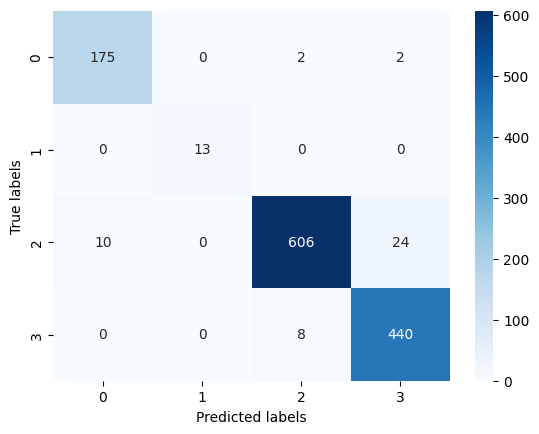

In [34]:
# Confusion Matrix
confusion_Matrix_cnn_resnet = confusion_matrix(y_test, y_pred_classes_cnn_resnet)
sns.heatmap(confusion_Matrix_cnn_resnet, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [35]:
# Classification Report
print(classification_report(y_test, y_pred_classes_cnn_resnet)) 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       179
           1       1.00      1.00      1.00        13
           2       0.98      0.95      0.96       640
           3       0.94      0.98      0.96       448

    accuracy                           0.96      1280
   macro avg       0.97      0.98      0.97      1280
weighted avg       0.96      0.96      0.96      1280



###  LIME Image Explainer

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


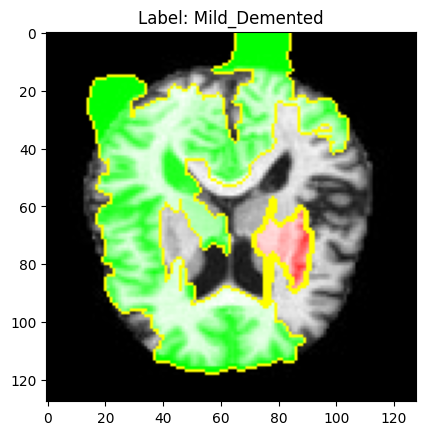

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


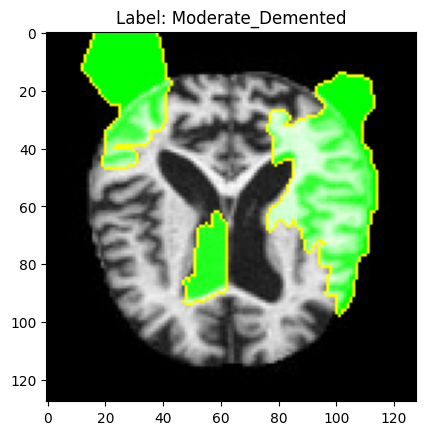

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


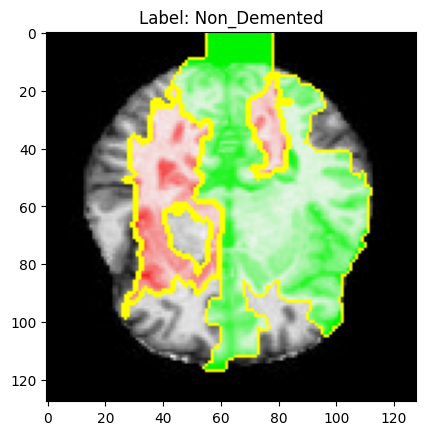

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


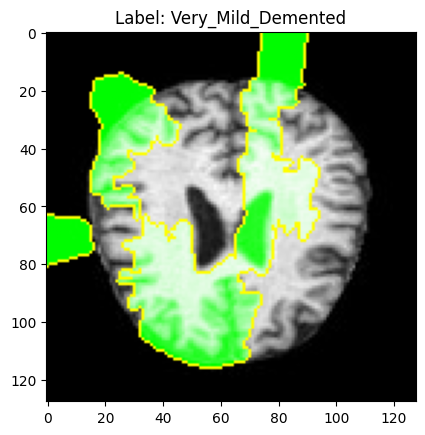

In [58]:
# Load CNN model
model = load_model('cnn_model.h5')

def model_predict(img_array):
    return model.predict(img_array)

base_path = "/Users/nataliamiela/Documents/master/ML2/project/data/Alzheimers"
labels_folders = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

sample_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        try:
            img = preprocess_image(image_path)
            sample_images.append((img, folder))  # Storing image with folder name as label
            break
        except Exception as e:
            print(f"Error processing file {image_name} in {folder}: {e}")

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Define segmentation function
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

for img, label in sample_images:
    # Prepare the image for LIME
    img_rgb = gray2rgb(img.squeeze())  # Convert grayscale to RGB
    img_rgb = np.expand_dims(img_rgb, axis=0)  # Add batch dimension

    # Explain the prediction
    explanation = explainer.explain_instance(img_rgb[0], lambda x: model_predict(np.expand_dims(rgb2gray(x), axis=3)), top_labels=5, hide_color=0, num_samples=1000, segmentation_fn=segmentation_fn)

    # Visualize the explanation for the top class
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Label: {label}")
    plt.show()
